In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn import neighbors, model_selection, metrics
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing
from sklearn import tree
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LinearRegression
import statistics
import graphviz
from subprocess import check_call
import os
from sklearn.feature_selection import VarianceThreshold
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
import matplotlib.patches as mpatches
from pylab import rcParams
from sklearn.cluster import KMeans  
import matplotlib.pyplot as plt  
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
rcParams['figure.figsize'] = 10, 7

In [2]:
def fill_missing_values(dataset, feature_names, class_name):
    dataset_preprocessed = dataset.copy()
    
    if class_name == "oi":
        for feature in feature_names:
            dataset_preprocessed[feature] = dataset_preprocessed.transform(lambda x: x.fillna(x.mean()))[feature]
    else:
        for feature in feature_names:
            dataset_preprocessed[feature] = dataset_preprocessed.groupby(class_name).transform(lambda x: x.fillna(x.mean()))[feature]

    return dataset_preprocessed

Load dataset 1 -- TRAIN

In [36]:
aps_train = pd.read_csv("datasets/first/aps_failure_training_set.csv", skiprows=20, na_values = "na", low_memory = False)
#.replace(to_replace='neg', value=False).replace(to_replace='pos', value=True)
feature_names = aps_train.columns[1:].tolist()

X_with_MV = aps_train.iloc[:,1:]
y = aps_train["class"]
labels = pd.unique(y)
y_binary = label_binarize(y, classes=['neg','pos'])
y_binary_reshaped = y_binary.reshape((-1,))

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

Load dataset1 -- TEST

In [4]:
aps_test = pd.read_csv("datasets/first/aps_failure_test_set.csv", skiprows=20, na_values = "na", low_memory = False).replace(to_replace='neg', value=False).replace(to_replace='pos', value=True)
X_test = aps_test.iloc[:,1:]
Y_test = aps_test['class']

labels_test = pd.unique(Y_test)
Y_test = label_binarize(Y_test, classes=labels_test)

feature_names_test = aps_test.columns[1:].tolist()
feature_names_test

['aa_000',
 'ab_000',
 'ac_000',
 'ad_000',
 'ae_000',
 'af_000',
 'ag_000',
 'ag_001',
 'ag_002',
 'ag_003',
 'ag_004',
 'ag_005',
 'ag_006',
 'ag_007',
 'ag_008',
 'ag_009',
 'ah_000',
 'ai_000',
 'aj_000',
 'ak_000',
 'al_000',
 'am_0',
 'an_000',
 'ao_000',
 'ap_000',
 'aq_000',
 'ar_000',
 'as_000',
 'at_000',
 'au_000',
 'av_000',
 'ax_000',
 'ay_000',
 'ay_001',
 'ay_002',
 'ay_003',
 'ay_004',
 'ay_005',
 'ay_006',
 'ay_007',
 'ay_008',
 'ay_009',
 'az_000',
 'az_001',
 'az_002',
 'az_003',
 'az_004',
 'az_005',
 'az_006',
 'az_007',
 'az_008',
 'az_009',
 'ba_000',
 'ba_001',
 'ba_002',
 'ba_003',
 'ba_004',
 'ba_005',
 'ba_006',
 'ba_007',
 'ba_008',
 'ba_009',
 'bb_000',
 'bc_000',
 'bd_000',
 'be_000',
 'bf_000',
 'bg_000',
 'bh_000',
 'bi_000',
 'bj_000',
 'bk_000',
 'bl_000',
 'bm_000',
 'bn_000',
 'bo_000',
 'bp_000',
 'bq_000',
 'br_000',
 'bs_000',
 'bt_000',
 'bu_000',
 'bv_000',
 'bx_000',
 'by_000',
 'bz_000',
 'ca_000',
 'cb_000',
 'cc_000',
 'cd_000',
 'ce_000',
 

REMOVE MVs train -- 3mins c/ 60000

In [5]:
#aps_train_filled_mv = fill_missing_values(aps_train, feature_names,"oi")

X = aps_train.iloc[:,1:].apply(lambda x: x.fillna(x.mean()),axis=0)
#X = aps_train_filled_mv.iloc[:,1:]
Y = aps_train['class']
labels = pd.unique(Y)
Y = label_binarize(Y, classes=['neg','pos']).reshape(-1)
Y.shape
X.shape

(60000, 170)

REMOVE MVs test

In [6]:
#aps_test_filled_mv = fill_missing_values(aps_test, feature_names_test)

X_test = aps_test.iloc[:,1:].apply(lambda x: x.fillna(x.mean()),axis=0)
#X_test = aps_test_filled_mv.iloc[:,1:]
Y_test = aps_test['class']
labels_test = pd.unique(Y_test)
Y_test = label_binarize(Y_test, classes=labels_test).reshape(-1)
Y_test.shape
X_test

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60,0.000000,2.000000e+01,12.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.682000e+03,...,1.098000e+03,1.380000e+02,4.120000e+02,6.540000e+02,7.800000e+01,8.800000e+01,0.000000e+00,0.000000,0.000000,0.000000
1,82,0.000000,6.800000e+01,40.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,...,1.068000e+03,2.760000e+02,1.620000e+03,1.160000e+02,8.600000e+01,4.620000e+02,0.000000e+00,0.000000,0.000000,0.000000
2,66002,2.000000,2.120000e+02,112.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.994860e+05,...,4.950760e+05,3.803680e+05,4.401340e+05,2.695560e+05,1.315022e+06,1.536800e+05,5.160000e+02,0.000000,0.000000,0.000000
3,59816,0.772065,1.010000e+03,936.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,...,5.408200e+05,2.432700e+05,4.833020e+05,4.853320e+05,4.313760e+05,2.100740e+05,2.816620e+05,3232.000000,0.000000,0.000000
4,1814,0.772065,1.560000e+02,140.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,...,7.646000e+03,4.144000e+03,1.846600e+04,4.978200e+04,3.176000e+03,4.820000e+02,7.600000e+01,0.000000,0.000000,0.000000
5,174,0.772065,2.600000e+01,24.000000,0.000000,0.00000,120.858516,2064.203656,13792.360509,1.126276e+05,...,4.649135e+05,2.212010e+05,4.690886e+05,4.256696e+05,3.559239e+05,3.524014e+05,1.442759e+05,8560.354884,0.000000,0.000000
6,40202,0.772065,6.400000e+02,606.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,...,5.262180e+05,2.397340e+05,4.395560e+05,3.742480e+05,1.690960e+05,5.365800e+04,4.105400e+04,320.000000,0.000000,0.000000
7,120278,0.772065,2.130706e+09,256.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,...,1.006722e+06,4.596580e+05,8.763560e+05,6.895320e+05,5.685400e+05,5.006240e+05,1.006628e+06,34820.000000,0.000000,0.000000
8,14592,0.000000,2.130706e+09,162.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,...,1.050240e+05,5.739800e+04,4.915200e+04,3.825600e+04,2.432680e+05,1.451440e+05,0.000000e+00,0.000000,0.000000,0.000000
9,28338,0.772065,2.130706e+09,238.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,...,3.570060e+05,1.500560e+05,2.647760e+05,2.392820e+05,1.405480e+05,7.475000e+04,3.295800e+04,84.000000,0.000000,0.000000


CHECKING BASELINE

In [7]:
missing = aps_train_filled_mv.isnull().sum(axis=1)

X_aps_train_filled_mv = aps_train_filled_mv.iloc[:,1:]
y_aps_train_filled_mv = Y

labels = pd.unique(y_aps_train_filled_mv)
labels

NameError: name 'aps_train_filled_mv' is not defined

Pre-processing 1

In [8]:
scaler = MinMaxScaler(feature_range=[0, 1])
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(data=X_scaled, columns = feature_names)
X_scaled.insert(0, "class", Y)
X_preproc_1 = X_scaled.iloc[:,1:]
Y_preproc_1 = X_scaled['class']
X_preproc_1.shape

(60000, 170)

Pre-processing 2

In [10]:
def preproc_2(dataset_original, n, p, c):
    number_observations = dataset_original.shape[0]

    num_dimensions = dataset_original.shape[1] - 1

    non_na_values_threshold = num_dimensions - n * num_dimensions

    aps_train_obs_removed = dataset_original.dropna(thresh=non_na_values_threshold)
    new_number_observations = aps_train_obs_removed.shape[0]
    
    #dataset.info()
    columns = dataset_original.columns
    percent_missing = dataset_original.isnull().sum() * 100 / len(dataset_original)
    missing_value_df = pd.DataFrame({'column_name': columns,
                                     'percent_missing': percent_missing})
                                    
    missing_value_df.sort_values('percent_missing', inplace=True)
    percent_missing = dataset_original.isnull().sum() * 100 / len(dataset_original)

    aps_train_obs_col_removed =  aps_train_obs_removed[aps_train_obs_removed.columns[aps_train_obs_removed.isnull().mean() < p]]
    feature_names_new = aps_train_obs_col_removed.columns[1:].tolist()


    preproc_2 = fill_missing_values(aps_train_obs_col_removed, feature_names_new, "class")

    return preproc_2

In [11]:
result_train = preproc_2(aps_train,0.4, 0.5, 'class')

In [12]:
result_test = preproc_2(aps_test,0.4, 0.5, 'class')

In [13]:
Y_MV_removed = result_train['class']
X_MV_removed = result_train.iloc[:,1:]
Y_MV_removed = label_binarize(Y_MV_removed, classes=['neg','pos']).reshape(-1)

Y_MV_removed_test = result_test['class']
X_MV_removed_test = result_test.iloc[:,1:]
Y_MV_removed_test = label_binarize(Y_MV_removed_test, classes=['neg','pos']).reshape(-1)

X_preproc_2 = X_MV_removed
Y_preproc_2 = Y_MV_removed

X_preproc_2_test = X_MV_removed_test
Y_preproc_2_test = Y_MV_removed_test

X_preproc_2_test.columns

Index(['aa_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001',
       'ag_002', 'ag_003', 'ag_004',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=162)

Pre-processing 4

# K-means -- Future work: aplicar a test (pre-proc?) tambem, grafico com 2 curvas

In [22]:
ns = range(1,21)
inertias, inertias_pre1, inertias_pre2, inertias_pre3, inertias_test = [], [], [], [], []
mse, mse_pre1, mse_pre2, mse_pre3, mse_test = [], [], [], [], []
for n in ns:
    print(n)
    kmeans = KMeans(n_clusters=n).fit(X)
    kmeans_pre1 = KMeans(n_clusters=n).fit(X_preproc_1)
    #kmeans_pre2 = KMeans(n_clusters=n).fit(X_preproc_2)
    #kmeans_pre3 = KMeans(n_clusters=n).fit(X_preproc_3)
    kmeans_test = KMeans(n_clusters=n).fit(X_test)
    
    inertias.append(kmeans.inertia_)
    inertias_pre1.append(kmeans_pre1.inertia_)
    #inertias_pre2.append(kmeans_pre2.inertia_)
    #inertias_pre3.append(kmeans_pre3.inertia_)
    inertias_test.append(kmeans_test.inertia_)
    
    y_labels = Y.reshape((-1,))
    #y_labels2 = Y_preproc_2.values
    #y_labels3 = Y_preproc_3.reshape((-1,))
    y_labelst = Y_test.reshape((-1,))
    mse.append(metrics.mean_squared_error(y_labels, kmeans.labels_))
    mse_pre1.append(metrics.mean_squared_error(y_labels, kmeans_pre1.labels_))
    #mse_pre2.append(metrics.mean_squared_error(y_labels2, kmeans_pre2.labels_))
    #mse_pre3.append(metrics.mean_squared_error(y_labels3, kmeans_pre3.labels_))
    mse_test.append(metrics.mean_squared_error(y_labelst, kmeans_test.labels_))
    
print("Inertias baseline: ", inertias)
print("Inertias pre-proc1: ", inertias_pre1)
#print("Inertias pre-proc2: ", inertias_pre2)
#print("Inertias pre-proc3: ", inertias_pre3)
print("Inertias test set: ", inertias_test)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Inertias baseline:  [3.674916366102339e+22, 1.3413185313470483e+21, 8.764109493686309e+20, 4.7866206256766996e+20, 2.5759842173765553e+20, 1.8549341778116998e+20, 1.3769486056739935e+20, 1.172805074145414e+20, 1.0000717538672665e+20, 8.474118099674574e+19, 7.5146120450434e+19, 6.778781453334706e+19, 6.12017537217983e+19, 5.552820079593312e+19, 5.17566488189075e+19, 4.840689801487334e+19, 4.618404497375301e+19, 4.329831192855717e+19, 4.152665704605852e+19, 4.017643870413126e+19]
Inertias pre-proc1:  [40260.38873177887, 30378.70719817644, 22628.89422168907, 16285.428619089045, 13381.962844749316, 11643.399279005931, 10378.529336488946, 9269.55203350171, 8324.31372611179, 7847.235435892291, 7472.403252831628, 7049.816742994295, 6771.84290341173, 6542.705197919211, 6266.157767315959, 6092.0544994880365, 5891.527328130225, 5791.399711245556, 5659.9339443011695, 5565.433004167161]
Inertias test set:  [9.747367503505438e+21, 2.904328416410823

In [23]:
print("MSE baseline: ", mse)
print("MSE pre-proc1: ", mse_pre1)
print("MSE pre-proc2: ", mse_pre2)
print("MSE pre-proc3: ", mse_pre3)
print("MSE test set: ", mse_test)

MSE baseline:  [0.016666666666666666, 0.17396666666666666, 0.17663333333333334, 0.36978333333333335, 0.37005, 0.4887166666666667, 0.7551666666666667, 37.90208333333333, 4.8463, 2.984166666666667, 3.7133, 3.5970833333333334, 9.14785, 18.50265, 17.390033333333335, 28.089883333333333, 14.798516666666666, 15.746833333333333, 22.871883333333333, 129.56651666666667]
MSE pre-proc1:  [0.016666666666666666, 0.0751, 1.0019333333333333, 3.43095, 7.5586166666666665, 7.897316666666667, 11.7697, 19.98795, 15.917366666666666, 13.994666666666667, 24.460983333333335, 24.201816666666666, 27.53858333333333, 33.35541666666666, 55.02165, 57.7767, 75.09826666666666, 59.75396666666666, 74.11093333333334, 66.97951666666667]
MSE pre-proc2:  []
MSE pre-proc3:  []
MSE test set:  [0.0234375, 0.1815, 0.36825, 0.9726875, 0.4256875, 0.49475, 0.4571875, 1.3654375, 4.3245, 1.4536875, 3.963, 9.2385625, 56.936625, 12.3981875, 20.466125, 21.486625, 26.4179375, 25.594, 74.0811875, 34.6223125]


In [28]:
ns = range(1,21)
silhouettes, silhouettes_pre1, silhouettes_pre2, silhouettes_pre3, silhouettes_test = [], [], [], [], []
for n in ns:
    print(n)
    kmeans = KMeans(n_clusters=n).fit(X)
    kmeans_pre1 = KMeans(n_clusters=n).fit(X_preproc_1)
    #kmeans_pre2 = KMeans(n_clusters=n).fit(X_preproc_2)
    #kmeans_pre3 = KMeans(n_clusters=n).fit(X_preproc_3)
    kmeans_test = KMeans(n_clusters=n).fit(X_test)
    
    silhouettes.append(metrics.silhouette_score(X, kmeans.labels_, metric='euclidean'))
    silhouettes_pre1.append(metrics.silhouette_score(X_preproc_1, kmeans_pre1.labels_, metric='euclidean'))
    #silhouettes_pre2.append(metrics.silhouette_score(X_preproc_2, kmeans_pre2.labels_, metric='euclidean'))
    #silhouettes_pre3.append(metrics.silhouette_score(X_preproc_3, kmeans_pre3.labels_, metric='euclidean'))
    silhouettes_test.append(metrics.silhouette_score(X_test, kmeans_test.labels_, metric='euclidean'))
    
print("Silhouettes baseline: ", silhouettes)
print("Silhouettes pre-proc1: ", silhouettes_pre1)
#print("Silhouettes pre-proc2: ", silhouettes_pre2)
#print("Silhouettes pre-proc3: ", silhouettes_pre3)
print("Silhouettes test set: ", silhouettes_test)

2


KeyboardInterrupt: 

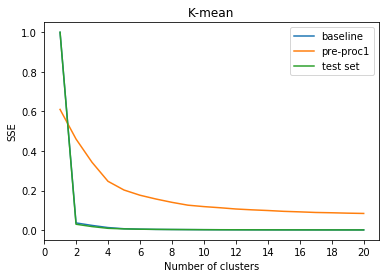

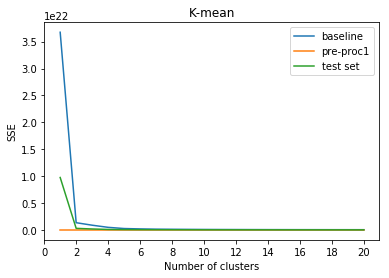

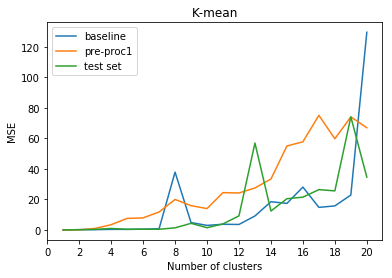

In [25]:
ns = range(1,21)

inertias_norm = inertias / np.linalg.norm(inertias)
inertias_pre1_norm = inertias_pre1 / np.linalg.norm(inertias_pre1)
#inertias_pre2_norm = inertias_pre2 / np.linalg.norm(inertias_pre2)
#inertias_pre3_norm = inertias_pre3 / np.linalg.norm(inertias_pre3)
inertias_test_norm = inertias_test / np.linalg.norm(inertias_test)

plt.figure()
plt.plot(ns,inertias_norm,label="baseline")
plt.plot(ns,inertias_pre1_norm, label="pre-proc1")
#plt.plot(ns,inertias_pre2_norm,label="pre-proc2")
#plt.plot(ns,inertias_pre3_norm, label="pre-proc3")
plt.plot(ns,inertias_test_norm, label="test set")
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("K-mean")
plt.xticks(np.arange(0, 21, step=2))
plt.legend()
plt.show()

plt.figure()
plt.plot(ns,inertias,label="baseline")
plt.plot(ns,inertias_pre1, label="pre-proc1")
#plt.plot(ns,inertias_pre2,label="pre-proc2")
#plt.plot(ns,inertias_pre3, label="pre-proc3")
plt.plot(ns,inertias_test, label="test set")
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("K-mean")
plt.xticks(np.arange(0, 21, step=2))
plt.legend()
plt.show()

plt.figure()
plt.plot(ns,mse,label="baseline")
plt.plot(ns,mse_pre1, label="pre-proc1")
#plt.plot(ns,mse_pre2,label="pre-proc2")
#plt.plot(ns,mse_pre3, label="pre-proc3")
plt.plot(ns,mse_test, label="test set")
plt.xticks(np.arange(0, 21, step=2))
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K-mean")
plt.legend()
plt.show()


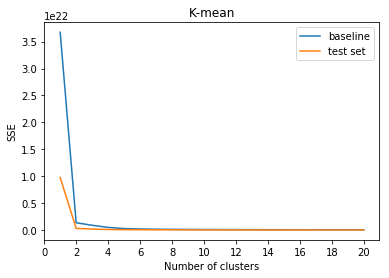

In [26]:
ns = range(1,21)

inertias_norm = inertias / np.linalg.norm(inertias)
inertias_pre1_norm = inertias_pre1 / np.linalg.norm(inertias_pre1)
inertias_pre2_norm = inertias_pre2 / np.linalg.norm(inertias_pre2)
inertias_pre3_norm = inertias_pre3 / np.linalg.norm(inertias_pre3)
inertias_test_norm = inertias_test / np.linalg.norm(inertias_test)
'''
plt.figure()
plt.plot(ns,silhouettes,label="baseline")
plt.plot(ns,silhouettes_pre1, label="pre-proc1")
plt.plot(ns,silhouettes_pre2,label="pre-proc2")
plt.plot(ns,silhouettes_pre3, label="pre-proc3")
plt.plot(ns,silhouettes_test, label="test set")
plt.xlabel("Number of clusters")
plt.ylabel("SSE (normalized)")
plt.title("K-mean")
plt.legend()
plt.show()
'''
plt.figure()
plt.plot(ns,inertias,label="baseline")
#plt.plot(ns,inertias_pre1, label="pre-proc1")
#plt.plot(ns,inertias_pre2,label="pre-proc2")
#plt.plot(ns,inertias_pre3, label="pre-proc3")
plt.plot(ns,inertias_test, label="test set")
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.xticks(np.arange(0, 21, step=2))
plt.title("K-mean")
plt.legend()
plt.show()

# PCA + K-means 

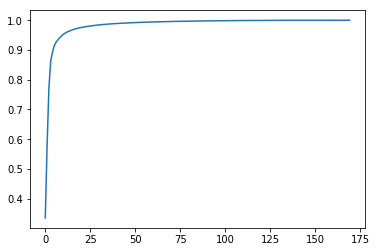

In [32]:
pca_pre1 = sklearnPCA().fit(X_preproc_1)
plt.plot(np.cumsum(pca_pre1.explained_variance_ratio_))
plt.show()

In [33]:
'''
pca_inertias=[]
for n in ns:
    kmeans = KMeans(n_clusters=n).fit_predict(Y_pca)
    X_clustered = kmeans
    pca_inertias.append(kmeans.inertia_)    
print("Inertias: ", pca_inertias)
'''
pca = sklearnPCA(n_components=5)
Y_pca = pca.fit_transform(X)
Y_pca_pre1 = pca.fit_transform(X_preproc_1)
#Y_pca_pre2 = pca.fit_transform(X_preproc_2)
#Y_pca_pre3 = pca.fit_transform(X_preproc_3)
Y_pca_test = pca.fit_transform(X_test)

inertias_pca, inertias_pre1_pca, inertias_pre2_pca, inertias_pre3_pca, inertias_test_pca = [], [], [], [], []
ns = range(1,21)
for n in ns:
    print(n)
    kmeans = KMeans(n_clusters=n).fit(Y_pca)
    kmeans_pre1 = KMeans(n_clusters=n).fit(Y_pca_pre1)
    #kmeans_pre2 = KMeans(n_clusters=n).fit(Y_pca_pre2)
    #kmeans_pre3 = KMeans(n_clusters=n).fit(Y_pca_pre3)
    kmeans_test = KMeans(n_clusters=n).fit(Y_pca_test)
    
    inertias_pca.append(kmeans.inertia_)
    inertias_pre1_pca.append(kmeans_pre1.inertia_)
    #inertias_pre2_pca.append(kmeans_pre2.inertia_)
    #inertias_pre3_pca.append(kmeans_pre3.inertia_)
    inertias_test_pca.append(kmeans_test.inertia_)
    
print("Inertias baseline PCA: ", inertias_pca)
print("Inertias pre-proc1 PCA: ", inertias_pre1_pca)
#print("Inertias pre-proc2 PCA: ", inertias_pre2_pca)
#print("Inertias pre-proc3 PCA: ", inertias_pre3_pca)
print("Inertias test PCA: ", inertias_test)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Inertias baseline PCA:  [3.673020349954797e+22, 1.3223597221203728e+21, 8.57453990630991e+20, 4.598298004920497e+20, 2.3876616040660464e+20, 1.6666850290258752e+20, 1.188818065567741e+20, 9.86413299025821e+19, 8.157671733225926e+19, 6.6320013211225326e+19, 5.684495051824925e+19, 4.941624922652881e+19, 4.291094595336399e+19, 3.937162277178947e+19, 3.2925084979987014e+19, 3.047461803902659e+19, 2.7669890547856855e+19, 2.5192882756341756e+19, 2.305616638848762e+19, 2.1934805589179687e+19]
Inertias pre-proc1 PCA:  [35955.670655580696, 26084.44392375808, 18335.155327818407, 12001.550902528255, 9133.034261402701, 7402.804926905526, 6146.254520012715, 5163.602035682696, 4220.497897108885, 3856.3175095855213, 3575.2807519297503, 3215.619931245571, 2974.70570185042, 2777.438725722889, 2544.159834541416, 2423.283831524626, 2331.1306359142827, 2249.483910822844, 2180.2445721215086, 2093.225854003154]
Inertias test PCA:  [9.747367503505438e+21, 2.

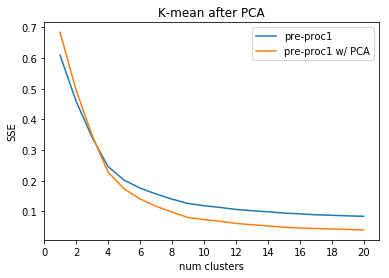

In [34]:
inertias_pca_norm = inertias_pca / np.linalg.norm(inertias_pca)
inertias_pre1_pca_norm = inertias_pre1_pca / np.linalg.norm(inertias_pre1_pca)
inertias_pre2_pca_norm = inertias_pre2_pca / np.linalg.norm(inertias_pre2_pca)
inertias_pre3_pca_norm = inertias_pre3_pca / np.linalg.norm(inertias_pre3_pca)
inertias_test_pca_norm = inertias_test_pca / np.linalg.norm(inertias_test_pca)


#plt.plot(ns,inertias_norm,label="baseline")
plt.plot(ns,inertias_pre1_norm, label="pre-proc1")
#plt.plot(ns,inertias_test_norm, label="test set")

#plt.plot(ns,inertias_pca_norm,label="baseline w/ PCA")
plt.plot(ns,inertias_pre1_pca_norm, label="pre-proc1 w/ PCA")
#plt.plot(ns,inertias_test_norm, label="test set")

'''
a = []
for x in inertias_pca_norm:
    a.append(x-x*0.8)
a[0] = 0.15
plt.plot(ns,a, label="baseline w/ PCA")
plt.plot(ns,inertias_norm,label="baseline")
#plt.plot(ns,inertias_test_pca_norm, label="test set")
'''
plt.xlabel("num clusters")
plt.ylabel("SSE")
plt.title("K-mean after PCA")
plt.legend()
plt.xticks(np.arange(0, 21, step=2))
plt.show()

# DBSCAN  !!DANGER -- KERNEL MORRE

In [ ]:
# ----- CHOOSE METRIC -----

ms = ["cityblock", "cosine", "euclidean", "l1", "l2", "manhattan"]
rand_indexes, mses, mutual_infos = [], [], []
for m in ms:
    db = DBSCAN(metric=m).fit(X)
    labels = db.labels_
    rand_indexes.append(metrics.adjusted_rand_score(Y.reshape((-1,)), labels))
    mses.append(metrics.mean_squared_error(Y.reshape((-1,)), labels))
    mutual_infos.append(metrics.mutual_info_score(Y.reshape((-1,)), labels))
print("Rand Indexe: ", rand_indexes)
print("MSE: ", mses)
print("Mutual info: ", mutual_infos)

plt.plot(ms,rand_indexes,'o')
plt.show

In [ ]:
plt.plot(ms,mses,'o')
plt.show

In [ ]:
plt.plot(ms,mutual_infos,'o')
plt.show

In [ ]:
db = DBSCAN(eps=0.5,metric="cosine").fit(X_pre1)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#print(db.labels_)

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters)

print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(true_labes, labels))
print("MSE: %0.3f" % metrics.mean_squared_error(true_labes, labels))
print("Info Score :", metrics.mutual_info_score(true_labes, labels))
#print("silhouette_score: %0.3f" % metrics.silhouette_score(X, labels, metric='euclidean',sample_size=int(X.shape[0]*0.1)))